## Imports and path

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scp

figure_path = "../figures/"

## Visualization

In [43]:
# Visualization settings
sns.set(
    context='talk', 
    font_scale=1.0, 
    font="Arial", 
    color_codes=True, 
    palette='deep', 
    style='ticks',
    rc={
        'mathtext.fontset': 'cm', 
        'xtick.direction': 'in', 
        'ytick.direction': 'in',
        'axes.linewidth': 3, 
        'figure.dpi': 70, 
        'text.usetex': False, 
        'font.size': 24
    }
)

## Helper functions

In [44]:
def semplot(x, y, smooth_param, i, label_param=None):
    
    if smooth_param > 0:
        y = scp.ndimage.gaussian_filter1d(y, sigma=smooth_param, axis=1)
    
    sem = np.std(y, axis=0) / np.sqrt(y.shape[0])
    mean = np.mean(y, axis=0)
    
    ax[i].plot(x, mean, label=label_param)
    ax[i].fill_between(x, mean - sem, mean + sem, alpha=0.25)

def log_regression(x,y):

    # Transform data to log scale
    log_x = np.log(x)
    log_y = np.log(y)

    # Perform linear regression on the log-transformed data
    slope, intercept, r_value, p_value, std_err = scp.stats.linregress(log_x, log_y)

    # Calculate predicted values
    log_y_pred = intercept + slope * log_x

    # Calculate residuals
    residuals = log_y - log_y_pred

    # Estimate standard error of the residuals
    s_res = np.sqrt(np.sum(residuals**2) / (len(log_y) - 2))

    # Calculate confidence intervals for the regression line
    n = len(log_x)
    mean_log_x = np.mean(log_x)
    t_value = scp.stats.t.ppf(1-0.01, n - 2)

    log_x_vals = np.linspace(np.log(1), np.log(100), 100)
    log_y_pred_vals = intercept + slope * log_x_vals
    se_line = s_res * np.sqrt(1/n + (log_x_vals - mean_log_x)**2 / np.sum((log_x - mean_log_x)**2))

    # Confidence interval for the regression line
    ci_upper = log_y_pred_vals + t_value * se_line
    ci_lower = log_y_pred_vals - t_value * se_line

    # Exponentiate the log values back to the original scale
    x_vals = np.exp(log_x_vals)
    y_pred_vals = np.exp(log_y_pred_vals)
    y_upper = np.exp(ci_upper)
    y_lower = np.exp(ci_lower)

    return(x_vals,y_pred_vals,y_upper,y_lower,slope,r_value,p_value)



## Bayesian model

In [189]:
def response_function(pis, rhos, gamma_p):
    p_sum = np.sum([pi * np.transpose(rho) for pi, rho in zip(pis, rhos)], axis=0)
    F_sum = np.sum([pi * np.cumsum(np.transpose(rho)) + (1 - pi) for pi, rho in zip(pis, rhos)], axis=0)

    # Ensure minimum value in F_sum
    F_sum = np.maximum(F_sum, 10**-1)
    opt_res = np.sqrt(gamma_p * p_sum / F_sum) - 1

    # Apply threshold to ensure positive response
    response = opt_res * (opt_res > 0)
    return response


def sigmoid(likelihoods, epsilons):
    associations = np.zeros_like(likelihoods)
    delta_likelihood = likelihoods[1] - likelihoods[0]

    # Prevent overflow in exponential calculation
    if delta_likelihood + epsilons[1] > 700:
        delta_likelihood = 700 - epsilons[1]

    exp_value = np.exp(delta_likelihood + epsilons[1])
    associations[0] = 1 / (1 + exp_value)
    associations[1] = exp_value / (1 + exp_value)

    return associations


def softmax(likelihoods, epsilons):
    associations = np.zeros_like(likelihoods)
    adjusted_likelihoods = likelihoods[1:] - likelihoods[0] + epsilons

    # Clip to avoid numerical overflow
    adjusted_likelihoods = np.clip(adjusted_likelihoods, -700, None)
    exp_values = np.exp(adjusted_likelihoods)
    sum_likelihoods = 1 + np.sum(exp_values)

    # Calculate associations
    associations[1:] = exp_values / sum_likelihoods
    associations[0] = 1 / sum_likelihoods

    return associations


def bayesian_model(T, C, epsilon, number_trials=100, pre_training_trials=100, t_max=100):
    tau1 = 1
    k = 100
    c = 1 / k
    gamma_p = 1000

    epsilons = np.array([0, epsilon])
    n_mu = int(((np.log(t_max) - np.log(tau1)) / np.log(1 + c)) + 3) - 1
    bin_size = 3
    n_bins = bin_size * t_max
    time_range = np.linspace(0, t_max, n_bins + 1)

    alphas = 10**-16 * np.ones([2, n_mu])
    weights = np.zeros([2, n_mu])
    likelihoods = np.zeros(2)
    associations = np.zeros([number_trials, 2])
    interval = np.zeros([2, n_bins + 1])
    response = np.zeros([number_trials, n_bins + 1])
    likelihood_history = np.zeros([number_trials, 2])

    # Compute tau_m values
    tau_m = tau1 * (1 + c) ** np.arange(n_mu)

    # Precompute density matrix
    density_matrix = np.zeros([n_bins + 1, n_mu])
    for mu in range(n_mu):
        g_p = scp.stats.gamma(k, scale=(tau_m[mu] / k))
        density_matrix[:, mu] = g_p.pdf(time_range)

    # Find indices for reinforcement times
    index_T = np.searchsorted(tau_m, T)
    index_C = np.searchsorted(tau_m, C)
    index_T_linear = np.searchsorted(time_range, T)

    # Pre-training phase
    for _ in range(pre_training_trials):
        alphas[0, index_C] += 1
        weights[0, :] = np.random.dirichlet(alphas[0, :])
        interval[0, :] = np.dot(density_matrix, weights[0, :])
        likelihoods[0] += interval[0, bin_size * C]

    # Main trials
    for n in range(number_trials):
        alphas[0, index_C] += 1
        alphas[1, index_T] += 1

        weights[0, :] = np.random.dirichlet(alphas[0, :])
        weights[1, :] = np.random.dirichlet(alphas[1, :])

        interval[0, :] = np.dot(density_matrix, weights[0, :])
        interval[1, :] = np.dot(density_matrix, weights[1, :])

        likelihoods[0] += np.log(interval[0, bin_size * C])
        likelihoods[1] += np.log(interval[1, bin_size * T])

        likelihood_history[n, :] = likelihoods
        associations[n] = sigmoid(likelihoods, epsilons)
        response[n, :] = response_function(associations[n, :], interval, gamma_p)

    return response, index_T_linear, time_range, associations, likelihood_history


## Event generation

In [133]:
def generate_event_sequence(reward_information, cues_information, max_cycles):
    """
    Generate a sequence of events based on reward and cue information.

    Parameters:
    - reward_information: [time to next reward, probability of reward]
    - cues_information: List of cues with [time to reward, probability of cue]
    - max_cycles: Maximum number of cycles to consider

    Returns:
    - A two-column array, with event times in the first column and event types in the second column.
    """
    events = np.empty((0, 2))  # Initialize an empty array for events

    # Generate reward times
    reward_time = np.linspace(reward_information[0], reward_information[0] * max_cycles, max_cycles)

    # Process cues
    for cue_index, cue_info in enumerate(cues_information):
        cue_time = reward_time - cue_info[0]

        # Remove cues based on probability
        assert cue_info[1] > 0, "Cue probability must be greater than 0."
        cue_time_removal = cue_time[::int((1 - cue_info[1]) * max_cycles) + 1]

        # Stack cue times with their event types
        time_type = np.stack([cue_time_removal, np.full(len(cue_time_removal), cue_index + 1)], axis=1)

        # Append to events
        events = np.vstack([events, time_type]) if events.size > 0 else time_type

    # Process rewards
    assert reward_information[1] > 0, "Reward probability must be greater than 0."
    reward_time_removal = reward_time[::int((1 - reward_information[1]) * max_cycles) + 1]

    # Stack reward times with event type 0
    reward_data = np.stack([reward_time_removal, np.zeros(len(reward_time_removal))], axis=1)

    # Append rewards to events
    events = np.vstack([events, reward_data]) if events.size > 0 else reward_data

    # Sort events by time and return
    return events[np.argsort(events[:, 0])]


def generate_events(paramDicts):
    """
    Generate multiple sequences of events and concatenate them.

    Parameters:
    - paramDicts: List of dictionaries with keys matching `generate_event_sequence`

    Returns:
    - An array of the last timestamps for each sequence
    """
    all_sequences = []

    lastTimestamp = 0  # Initialize the last timestamp
    
    for params in paramDicts:
        sequence = generate_event_sequence(**params)
        sequence[:, 0] += lastTimestamp  # Increase the values in the first column
        all_sequences.append(sequence)
        
        # Update last timestamp for the next sequence
        lastTimestamp = sequence[-1, 0] 
        
    # Convert list of sequences to a 2D NumPy array
    concatenated_sequences = np.concatenate(all_sequences)
    return concatenated_sequences


## TCL (Temporal Causal Learning) model

In [267]:
def run_tcl(event_sequence, epsilon, eta, eta_prime):
    """
    Simulates the online Temporal Causal Learning (TCL) model based on provided parameters and event sequence.

    Parameters:
    - event_sequence: ndarray of shape (n_events, 2)
        An array with event times (column 0) and event types (column 1).
    - epsilon: float
        The relative log-prior for the causal learning signals.
    - eta: float
        Learning rate for updating temporal weights.
    - eta_prime: float
        Learning rate for updating causal learning signals.

    Returns:
    - dict:
        A dictionary containing the following keys:
        - 'CausalLearning': The evolution of causal learning signals over trials for each event type.
        - 'Responses': The computed response signal over the full time.
        - 'Weights': The evolution of temporal weights over trials.
        - 'Associations': The evolution of association probabilities over trials for event types.
    """

    # Constants
    GAMMA = 1000  # Scaling factor for response computation
    K = 100  # Shape parameter for gamma distribution
    BINS = 3  # Number of bins per time unit for temporal resolution

    # Extract event times and types from the sequence
    event_times = event_sequence[:, 0]
    event_types = event_sequence[:, 1].astype(int)
    total_time = event_times[-1]

    # Compute the maximum time range (t_max) based on reward timing
    reward_indices = np.where(event_sequence[:, 1] == 0)[0]
    t_max = int(
        np.max(
            event_sequence[reward_indices, 0] - event_sequence[reward_indices - 1, 0]
        )
        * 1.5
    )

    # Define simulation time ranges
    n_bins = BINS * t_max  # Total bins for the time range
    time_range = np.linspace(0, t_max, n_bins + 1)  # Time range for one event
    total_time_range = np.linspace(
        0, int(total_time + len(time_range)), int(total_time + len(time_range)) * BINS + 1
    )
    response_array = np.zeros_like(total_time_range)  # Initialize the response array

    # Define time constants for eligibility traces (τ_m)
    n_mu = round((np.log(t_max) / np.log(1 + 1 / K)) + 3)
    tau_m = np.array([(1 + 1 / K) ** (mu - 1) for mu in range(1, n_mu)])

    # Initialize weights, densities, and other parameters
    num_events = len(np.unique(event_types))  # Number of unique event types
    weights = np.full((len(tau_m), num_events), 1e-16)  # Temporal weights
    density_matrix = np.array(
        [
            scp.stats.gamma(K, scale=tau / K).pdf(time_range)
            for tau in tau_m
        ]
    ).T  # Temporal density matrix for time bins

    # Initialize variables for causal inference
    posteriors = np.zeros((num_events, n_bins + 1))  # Event to reward posterior distribution
    epsilons = np.ones(num_events) * epsilon  # Relative log-prior
    epsilons[0] = 0  # Rewards have no epsilon
    causal_learning = np.zeros(num_events)  # Causal learning signals for each event type
    last_times = -np.ones(num_events)  # Last observed times for each event type
    log_likelihoods = np.zeros(num_events)  # Log-likelihood contributions for events
    probabilities = np.zeros(num_events)  # Association probabilities
    presences = np.zeros(num_events)  # Event presence flags

    # Initialize history trackers
    causal_learning_evolution = [[] for _ in range(num_events)]  # Causal learning signals over time
    association_evolution = [[] for _ in range(num_events)]  # Associations over time
    weights_evolution = [[] for _ in range(num_events)]  # Weights over time

    # Helper functions
    def update_weights(event_type, eta):
        """
        Update the temporal weights for a specific event type.
        """
        for mu in range(n_mu - 1):
            weights[mu, event_type] -= eta * weights[mu, event_type]

    def compute_eligibility_trace(elapsed_time):
        """
        Compute the eligibility trace for a given elapsed time.
        """
        return np.array([(1 / tau) * np.exp(-elapsed_time / tau) for tau in tau_m])

    def update_causal_learning_and_probabilities():
        """
        Update the causal learning signals and association probabilities for all event types.
        Uses the current log-likelihoods and the relative log-prior.
        """
        for event in range(1, num_events):
            if presences[event] and log_likelihoods[event] != 0:
                causal_learning[event] = (
                    log_likelihoods[event]
                    + (1 - eta_prime) * causal_learning[event]
                    - log_likelihoods[0]
                )

        # Compute association probabilities using a softmax transformation
        for event in range(num_events):
            causal_learning[event] = min(causal_learning[event], 700)  # Avoid overflow
            probabilities[event] = np.clip(
                np.exp(causal_learning[event] + epsilons[event])
                / np.sum(np.exp(causal_learning + epsilons)),
                0.01,
                0.99,
            )

    def shift_posteriors():
        """
        Shift the posteriors to align with the most recent event for temporal integration.
        """
        posteriors_shifted = np.zeros([num_events, BINS * t_max + 1])
        for event in range(num_events):
            if last_times[event] != -1:
                dt = event_time - last_times[event]
                index_dt = np.searchsorted(time_range, dt)
                if index_dt < BINS * t_max:
                    posteriors_shifted[event, 0 : BINS * t_max - index_dt] = posteriors[
                        event, index_dt : BINS * t_max
                    ]
        return posteriors_shifted

    def online_response_function(posteriors_shifted, probabilities, GAMMA):
        """
        Compute the response function based on probabilities and posteriors.
        """
        p_sum = np.sum([prob * post for prob, post in zip(probabilities, posteriors_shifted)], axis=0)
        F_sum = np.sum([prob * np.cumsum(post) + (1 - prob) for prob, post in zip(probabilities, posteriors_shifted)], axis=0)
        F_sum[F_sum < 1e-1] = 1e-1
        opt_res = np.sqrt(GAMMA * p_sum / F_sum) - 1
        opt_res = opt_res * (opt_res > 0)
        
        return opt_res

    def store_evolution_data():
        """
        Store the evolution of causal learning signals, weights, and associations.
        """
        for event in range(num_events):
            causal_learning_evolution[event].append(causal_learning[event].copy())
            weights_evolution[event].append(weights[:, event].copy())
            association_evolution[event].append(probabilities[event])

    # Start the simulation
    for i, (event_time, event_type) in enumerate(zip(event_times, event_types)):
        if event_type > 0:  # Non-reward event
            update_weights(event_type, eta)
            posteriors[event_type, :] = np.dot(density_matrix, weights[:, event_type])
            last_times[event_type] = event_time

            # Shift the posteriors and compute response
            posteriors_shifted = shift_posteriors()
            response = online_response_function(posteriors_shifted, probabilities, GAMMA)

            # Update response array
            index_event = np.searchsorted(total_time_range, event_time)
            response_array[index_event : index_event + len(time_range)] = response

            # Mark presence and store data
            presences[event_type] = 1
            store_evolution_data()

        elif event_type == 0:  # Reward event
            for event in range(num_events):
                if presences[event] == 1:
                    last_event_idx = np.where(event_types[:i] == event)[0][-1]
                    elapsed_time = event_time - event_times[last_event_idx]

                    # Update weights and causal learning signal if within time range
                    if elapsed_time < time_range[-1]:
                        eligibility_trace = compute_eligibility_trace(elapsed_time)
                        weights[:, event] += eta * (
                            np.eye(len(tau_m))[np.argmax(eligibility_trace)]
                            - (weights[:, event] if event == 0 else 0)
                        )
                        posteriors[event, :] = np.dot(density_matrix, weights[:, event])
                        log_likelihoods[event] = (
                            np.log(
                                posteriors[event, np.searchsorted(time_range, elapsed_time)]
                            )
                            if elapsed_time < len(posteriors[event])
                            else 0
                        )
                    else:
                        log_likelihoods[event] = 0

            # Update causal inference and response
            update_causal_learning_and_probabilities()
            last_times[event_type] = event_time
            posteriors_shifted = shift_posteriors()

            # Compute response for reward events
            response = online_response_function(posteriors_shifted, probabilities, GAMMA)
            index_event = np.searchsorted(total_time_range, event_time)
            response_array[index_event : index_event + len(time_range)] = response
            presences[0] = 1

    # Final response array over full time range
    response_array = np.vstack([total_time_range, response_array])

    return {
        "CausalLearning": np.array(causal_learning_evolution),
        "Responses": response_array,
        "Weights": np.array(weights_evolution),
        "Associations": np.array(association_evolution),
    }


# Figure 1: Learning phenomena in a classical conditioning paradigm

## Discontinuous learning curves in experiments (figure 1b)

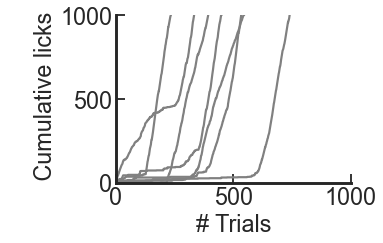

In [87]:
data_path = "../data/Jeong_2022.pkl"
data = np.load(data_path, allow_pickle=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot cumulative licks for each entry in the data
for i in range(np.size(data)):
    ax.plot(np.cumsum(data[i]["licks"]), color='grey', alpha=1)

# Set axis limits and ticks
ax.set_xlim([0, 1000])
ax.set_ylim([0, 1000])
ax.set_xticks([0, 500, 1000])
ax.set_xticklabels([0, 500, 1000], fontsize=24)
ax.set_yticks([0, 500, 1000])
ax.set_yticklabels([0, 500, 1000], fontsize=24)

# Set labels and remove top/right spines
ax.set_xlabel('# Trials', fontsize=24)
ax.set_ylabel('\n Cumulative licks', fontsize=24)
ax.spines[['right', 'top']].set_visible(False)

# Adjust layout and save figure
plt.tight_layout()
#plt.savefig(figure_path + "figure1b.svg")


## Time-scale invariant learning in experiments (figure 1c)

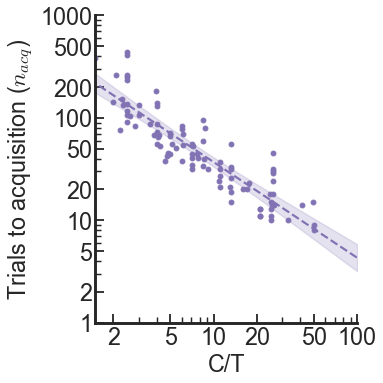

In [39]:
# Path
data_path = "../data/Gibbon_Balsam_1981.csv"

fig, ax = plt.subplots(figsize=(6, 6))

# Load data
df = pd.read_csv(data_path, decimal=',', delimiter=';').to_numpy()
x, y = df[:, 0], df[:, 1]

# Experimental points
ax.loglog(
    x, y, '.', 
    color=sns.color_palette("deep")[4], 
    alpha=1, 
    label='Experimental points', 
    markersize=10
)

# Regression and confidence interval
[x_vals, y_pred_vals, y_upper, y_lower, slope, r_value, p_value] = log_regression(x, y)
ax.plot(
    x_vals, y_pred_vals, 
    color=sns.color_palette("deep")[4], 
    linestyle='--', 
    alpha=1, 
    label=f'Experimental fit, slope = {round(slope, 1)}'
)
ax.fill_between(
    x_vals, y_lower, y_upper, 
    color=sns.color_palette("deep")[4], 
    alpha=0.2, 
    label='Confidence interval (99%)'
)

# Axis limits and labels
ax.set_xlim([1.5, 100])
ax.set_ylim([1, 1000])
ax.set_xticks([2, 5, 10, 20, 50, 100])
ax.set_xticklabels([2, 5, 10, 20, 50, 100], fontsize=24)
ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
ax.set_yticklabels([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000], fontsize=24)
ax.set_xlabel('C/T', fontsize=24)
ax.set_ylabel('Trials to acquisition ($n_{acq}$)', fontsize=24)

# Simplify plot appearance
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

# Save figure
#plt.savefig(f"{figure_path}figure1c.svg")

## Time-scale invariance of responses profiles in experiments (figure 1d)

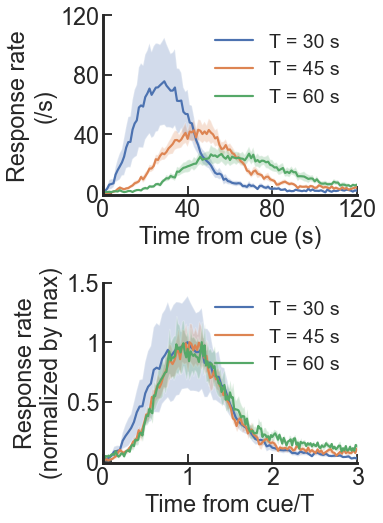

In [84]:
data_path = "../data/Church_1998.pkl"
responses = np.load(data_path,allow_pickle=True)

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# Plot raw response rates
for T in ["30", "45", "60"]:
    semplot(np.linspace(0,199,200), responses[T], 0, 0, f'T = {T} s')

ax[0].set(xlim=[0, 120], ylim=[-300/100, 300])
ax[0].set_xticks([0, 40, 80, 120],[0, 40, 80, 120], fontsize=24)
ax[0].set_yticks([0, 100, 200, 300],[0, 40, 80, 120], fontsize=24)
ax[0].set_xlabel('Time from cue (s)', fontsize=24)
ax[0].set_ylabel('Response rate\n(/s)', fontsize=24)

# Plot normalized response rates
for T in ["30", "45", "60"]:
    semplot(responses['Time'][1:] / int(T), responses[T] / np.max(np.mean(responses[T], 0)), 0, 1, f'T = {T} s')

ax[1].set(xlim=[0, 3], ylim=[-1.5/100, 1.5])
ax[1].set_xticks([0, 1, 2, 3],[0, 1, 2, 3], fontsize=24)
ax[1].set_yticks([0, 0.5, 1, 1.5],[0, 0.5, 1, 1.5], fontsize=24)
ax[1].set_xlabel('Time from cue/T', fontsize=24)
ax[1].set_ylabel('Response rate\n(normalized by max)', fontsize=24)

# General formatting
for a in ax:
    a.spines[['right', 'top']].set_visible(False)
ax[0].legend(frameon=False, fontsize=20)
ax[1].legend(frameon=False, fontsize=20)

plt.tight_layout()
#plt.savefig(figure_path + "figure1d.svg")


## Effect of prior rewards in experiments (figure 1e)

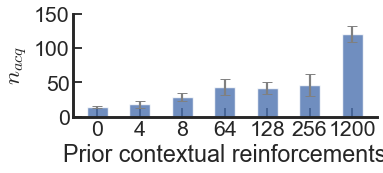

In [98]:
# Load data from CSV
data_path = "../data/Balsam_1981_1988.csv"
df = pd.read_csv(data_path, decimal=',', delimiter=';')

# Process data
N_pre = df["Mean"].to_numpy()
N_pre = np.delete(N_pre, np.isnan(N_pre))

SEM_pre = df["SEM"].to_numpy()
SEM_pre = np.delete(SEM_pre, np.isnan(SEM_pre))

# Create plot
fig, ax = plt.subplots(figsize=(6, 3))
x = np.array([0, 4, 8, 64, 128, 256, 1200])

# Bar plot
ax.bar(np.arange(len(x)), N_pre, color=sns.color_palette("deep")[0], width=0.5, label='Experiment', alpha=0.8)

# Error bars
ax.errorbar(np.arange(len(x)), N_pre, SEM_pre, linestyle='', color=sns.color_palette("deep")[0], capsize=5, ecolor='gray')

# Set axis labels and ticks
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, fontsize=22)

ax.set_yticks([0, 50, 100, 150])
ax.set_ylim([0, 150])
ax.set_yticklabels([0, 50, 100, 150], fontsize=22)

# Label axes
ax.set_ylabel("$n_{acq}$", fontsize=24)
ax.set_xlabel("Prior contextual reinforcements", fontsize=24)

# Hide top and right spines
ax.spines[['right', 'top']].set_visible(False)

# Adjust layout and save figure
plt.tight_layout()
#plt.savefig(figure_path + "figure1e.svg")


# Figure 3: The Bayesian model reproduces timing-related phenomena

## Discontinuous learning curves in Bayesian model (figure 3a)

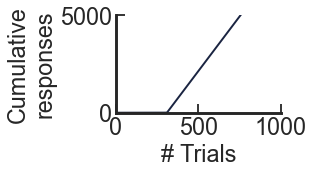

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))

# Run simulation
epsilon = -20
response, index_T, time_range, associations, likelihood_history = bayesian_model(
    T=10, C=20, epsilon=epsilon, number_trials=1000, t_max=1000, pre_training_trials=1000
)

# Extract and compute the cumulative licks for the target response
response_T = response[:, index_T]
cumulative_licks = np.cumsum(response_T)

# Plot cumulative responses
ax.plot(
    cumulative_licks,
    alpha=1,
    linewidth=2,
    color=sns.color_palette("cubehelix")[0]
)

# Configure plot limits and labels
ax.set_xlim([0, 1000])
ax.set_ylim([0, 5000])
ax.set_ylabel('Cumulative\nresponses', fontsize=24)
ax.set_xlabel('# Trials', fontsize=24)

# Customize ticks
ax.set_xticks([0, 500, 1000])
ax.set_xticklabels([0, 500, 1000], fontsize=24)
ax.set_yticks([0, 5000])
ax.set_yticklabels([0, 5000], fontsize=24)

ax.spines[['right', 'top']].set_visible(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(figure_path + "figure3a.svg")


## Time-scale invariance of response profiles in Bayesian model (figure 3b)

In [112]:
epsilon = -20
Ts = [30, 45, 60]
C = 200
max_t = C * 2
n_bins = max_t * 3 + 1

# Initialize responses array
responses = np.zeros((len(Ts), n_bins))

for i, T in enumerate(Ts):
    # Run simulation for each T
    response, index_T, time_range, associations, likelihood_history = bayesian_model(
        T, C, epsilon, number_trials=1000, pre_training_trials=0, t_max=max_t
    )
    responses[i, :] = response[-1, :]


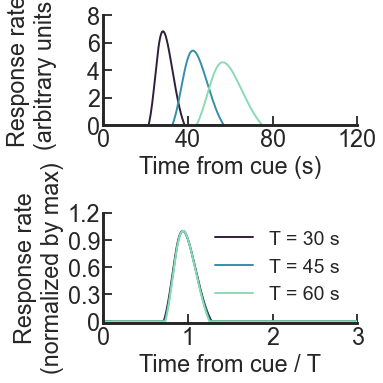

In [113]:
color_index = [0, 3, 5]
labels = ["T = 30 s", "T = 45 s", "T = 60 s"]

fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Plot raw responses
for i, T in enumerate(Ts):
    ax[0].plot(
        time_range,
        responses[i, :],
        linewidth=2,
        label=labels[i],
        color=sns.color_palette("mako")[color_index[i]],
    )
ax[0].set_ylim([-2 / 100, 8])
ax[0].set_xlim([0, 120])
ax[0].set_xlabel("Time from cue (s)", fontsize=24)
ax[0].set_ylabel("Response rate\n(arbitrary units)\n", fontsize=24)
ax[0].set_xticks([0, 40, 80, 120], [0, 40, 80, 120], fontsize=24)
ax[0].set_yticks([0, 2, 4, 6, 8], [0, 2, 4, 6, 8], fontsize=24)
ax[0].spines[["right", "top"]].set_visible(False)

# Plot normalized responses
for i, T in enumerate(Ts):
    ax[1].plot(
        time_range / T,
        responses[i, :] / max(responses[i]),
        linewidth=2,
        label=labels[i],
        color=sns.color_palette("mako")[color_index[i]],
    )
ax[1].set_ylim([-1.5 / 100, 1.2])
ax[1].set_xlim([0, 3])
ax[1].set_xlabel("Time from cue / T", fontsize=24)
ax[1].set_ylabel("Response rate\n(normalized by max)", fontsize=24)
ax[1].set_xticks([0, 1, 2, 3], [0, 1, 2, 3], fontsize=24)
ax[1].set_yticks([0, 0.3, 0.6, 0.9, 1.2], [0, 0.3, 0.6, 0.9, 1.2], fontsize=24)
ax[1].spines[["right", "top"]].set_visible(False)

# Add legend to the second subplot
ax[1].legend(frameon=False, fontsize=20)

# Tight layout and save the figure
plt.tight_layout()
plt.savefig(figure_path + "figure3b.svg")


## Time-scale invariant learning in Bayesian model (figure 3c)

In [106]:
# Define parameters
epsilons = [-5, -10, -15, -20]
ratios = np.geomspace(2.5, 100, 20)
acquisitions = np.zeros((len(epsilons), len(ratios)))
T = 5
acquisition_criteria=0.1

# Compute acquisitions for each epsilon and ratio
for eps_idx, epsilon in enumerate(epsilons):
    for ratio_idx, ratio in enumerate(ratios):
        C = int(ratio * T)          # Cycle time
        max_t = int(C * 2)          # Define maximum time

        # Run the Bayesian model
        response, index_T, time_range, associations, likelihood_history = bayesian_model(
            T, C, epsilon, number_trials=1000, pre_training_trials=1000, t_max=max_t
        )
        
        # Extract response and determine acquisition trial
        response_T = response[:, index_T]
        acquisition_trial = np.where(response_T > acquisition_criteria * np.max(response_T))[0][0]
        acquisitions[eps_idx, ratio_idx] = acquisition_trial


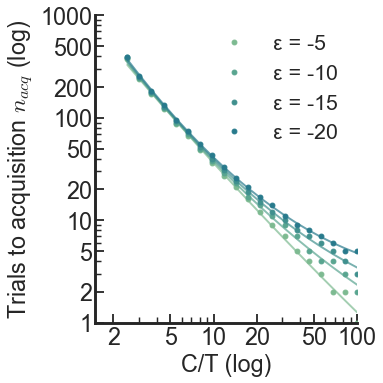

In [111]:
fig, ax = plt.subplots(figsize=(6, 6))

for i, epsilon in enumerate(epsilons):
    # Regression parameters
    x_vals, y_pred_vals, y_upper, y_lower, slope, r_value, p_value = log_regression(ratios, acquisitions[i, :])

    # Scatter plot of data
    ax.loglog(ratios, acquisitions[i, :], '.', color=sns.color_palette("crest")[i], alpha=1, markersize=10, label=r'ε = ' + str(epsilon))

    # Fit and plot a quadratic curve in log-log scale
    poly_coeff = np.polyfit(np.log(ratios), np.log(acquisitions[i, :]), 2)
    fitted_curve = np.polyval(poly_coeff, np.log(ratios))
    ax.plot(ratios, np.exp(fitted_curve), color=sns.color_palette("crest")[i], linestyle='-', linewidth=2, alpha=0.7)

# Plot adjustments
ax.set_xlim([1.5, 100])
ax.set_ylim([1, 1000])
ax.set_xticks([2, 5, 10, 20, 50, 100])
ax.set_xticklabels([2, 5, 10, 20, 50, 100], fontsize=24)
ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
ax.set_yticklabels([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000], fontsize=24)
ax.set_xlabel('C/T (log)', fontsize=24)
ax.set_ylabel(r'Trials to acquisition $n_{acq}$ (log)', fontsize=24)
ax.spines[['right', 'top']].set_visible(False)

# Legend
ax.legend(frameon=False, fontsize=22)

plt.tight_layout()
plt.savefig(figure_path + "figure3c.svg")


## Effect of prior rewards in Bayesian model (figure 3d)

In [114]:
# Define parameters
pre_training = np.array([0, 4, 8, 64, 128, 256, 1200])
epsilon = -20
T = 10
C = 30
acquisition_criteria = 0.1

# Initialize array to store acquisition results
acquisitions = np.zeros(pre_training.size)

# Run the simulation for each pre-training condition
for i, pre_trials in enumerate(pre_training):
    max_t = int(C * 2)
    response, index_T, time_range, associations, likelihood_history = bayesian_model(
        T, C, epsilon, number_trials=500, pre_training_trials=pre_trials, t_max=max_t
    )
    response_T = response[:, index_T]
    
    # Find acquisition trial
    acquisition = np.where(response_T > acquisition_criteria * np.max(response_T))[0][0]
    acquisitions[i] = acquisition


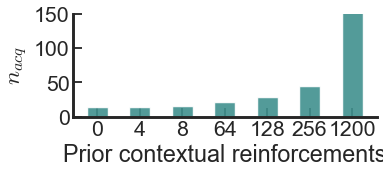

In [115]:
# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Define x values and plot the bar chart
x = np.array([0, 4, 8, 64, 128, 256, 1200])
ax.bar(
    np.arange(x.size),
    acquisitions,
    color=sns.color_palette("crest")[2],
    width=0.5,
    label="Model",
    alpha=0.9,
)

# Customize x and y ticks
ax.set_xticks(np.arange(x.size), labels=x, fontsize=22)
ax.set_yticks([0, 50, 100, 150], labels=[0, 50, 100, 150], fontsize=22)

# Set limits and labels
ax.set_ylim([0, 150])
ax.set_ylabel("$n_{acq}$", fontsize=24)
ax.set_xlabel("Prior contextual reinforcements", fontsize=24)

# Hide unnecessary spines
ax.spines[["right", "top"]].set_visible(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(figure_path + "figure3d.svg")


# Figure 4: TCL reproduces timescale-invariant learning

In [291]:
def get_acquisition(output, event_sequence, acquisition_criteria):

    # Extract reward times from the event sequence (event type 0)
    reward_times = event_sequence[event_sequence[:, 1] == 0, 0]

    # Retrieve the total time range and corresponding responses
    total_time_range = output["Responses"][0]
    response_values = output["Responses"][1]

    # Find the indices of reward times within the total time range
    reward_indices = np.searchsorted(total_time_range, reward_times)

    # Retrieve the responses corresponding to reward times
    reward_responses = response_values[reward_indices]

    # Determine the acquisition point based on the threshold
    threshold = acquisition_criteria * np.max(reward_responses)
    acquisition_index = np.where(reward_responses > threshold)[0][0]

    return acquisition_index


In [293]:
parameters_distribution = [ 
    {'reward_information': [150,1], 'cues_information': [], 'max_cycles': 500},
    {'reward_information': [150,1], 'cues_information': [[10,1]], 'max_cycles': 1000}
   # Add more parameter sets as needed
]

eta = 1.5 * 10**(-2)
eta_prime = 10**(-2)
eps = -20
acquisition_criteria = 0.1

ratios=np.geomspace(2.5,100,20)
acquisitions=np.zeros([np.size(ratios)])  

for i in range(np.size(ratios)):

    parameters_distribution[0]['reward_information'][0]=(ratios[i])*parameters_distribution[1]['cues_information'][0][0]
    parameters_distribution[1]['reward_information'][0]=(ratios[i])*parameters_distribution[1]['cues_information'][0][0]
    
    t_max=int(parameters_distribution[1]["reward_information"][0]+1)

    # Generating events
    event_sequence = generate_events(parameters_distribution)

    # Running simulation
    output_simulation = run_tcl(event_sequence,eps,eta,eta_prime) 
    acquisitions[i]=get_acquisition(output_simulation,event_sequence,acquisition_criteria)-parameters_distribution[0]['max_cycles']


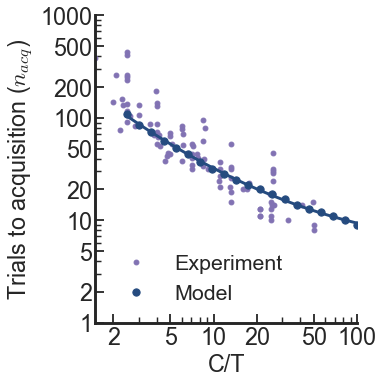

In [289]:
# Path
data_path = "../data/Gibbon_Balsam_1981.csv"

fig, ax = plt.subplots(figsize=(6, 6))

# Load data
df = pd.read_csv(data_path, decimal=',', delimiter=';').to_numpy()
x, y = df[:, 0], df[:, 1]

# Experimental points
ax.loglog(
    x, y, '.', 
    color=sns.color_palette("deep")[4], 
    alpha=1, 
    label='Experiment', 
    markersize=10
)

# Scatter plot of data
ax.loglog(ratios, acquisitions, '.', color=sns.color_palette("crest")[5], alpha=1, markersize=15,label='Model')

# Fit and plot a quadratic curve in log-log scale
poly_coeff = np.polyfit(np.log(ratios), np.log(acquisitions), 2)
fitted_curve = np.polyval(poly_coeff, np.log(ratios))
ax.plot(ratios, np.exp(fitted_curve), color=sns.color_palette("crest")[5], linestyle='-', linewidth=3, alpha=1)


# Axis limits and labels
ax.set_xlim([1.5, 100])
ax.set_ylim([1, 1000])
ax.set_xticks([2, 5, 10, 20, 50, 100])
ax.set_xticklabels([2, 5, 10, 20, 50, 100], fontsize=24)
ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
ax.set_yticklabels([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000], fontsize=24)
ax.set_xlabel('C/T', fontsize=24)
ax.set_ylabel('Trials to acquisition ($n_{acq}$)', fontsize=24)

# Simplify plot appearance
ax.spines[['right', 'top']].set_visible(False)

# Legend
ax.legend(frameon=False, fontsize=22)
plt.tight_layout()

# Save figure
plt.savefig(f"{figure_path}figure4.svg")

# Figure 5: TCL is consistent with classical conditioning results

## Extinction

In [ ]:

df = pd.read_csv(folder_path, decimal=',',delimiter=';')

Trials= df["Trial"].to_numpy()
Trials=np.delete(Trials,np.isnan(Trials))

x = [0,25,50,75,100,125,150,175]
N=np.zeros([5,np.size(x)])
for i in range(5):
    N[i,:]=(df[str(i+1)].to_numpy())

In [ ]:
parameters_distribution = [ 
    
    {'reward_information': [500,0,1,1], 'cues_information': [[10,0,1,1]], 'max_cycles': 500},
    {'reward_information': [500,0,0,0], 'cues_information': [[10,0,1,1]], 'max_cycles': 500}
   # Add more parameter sets as needed
]

beta = 0.01
epsilon= -20
learning_rate = 0.02

n_iteration = 1

responses = np.zeros([n_iteration,1000])


for i in range(n_iteration):
    t_max=int(parameters_distribution[0]["reward_information"][0]+1)
    time_range=np.linspace(0,t_max,3*t_max)
    T=parameters_distribution[1]['cues_information'][0][0]
    index_response = np.searchsorted(time_range,parameters_distribution[1]['cues_information'][0][0])
    event_sequence,time_stamps = generate_multiple_sequences(parameters_distribution)
    output_simulation = run_simulation_continuous(learning_rate,epsilon,beta,event_sequence,t_max,stochastic = False,k=100)    
    cue_times=event_sequence[np.where(event_sequence[:,1]==1)[0],0]
    total_time_range = output_simulation["Responses"][0]
    index_response=np.searchsorted(total_time_range,cue_times)
    responses[i,:] = output_simulation["Responses"][1][index_response+3*T]

In [ ]:

plt.rcParams.update({'font.size': 24})
sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks',
rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 3, 'figure.dpi':70, 'text.usetex':False, 'font.size':24})

fig, ax = plt.subplots(2,1,figsize=(5,7))

for i in range(5):
    ax[0].plot(x,N[i]/10,'.-',color=sns.color_palette("deep")[4])
    ax[1].plot(np.linspace(1,500,500),responses[0,500:1000]/np.max(responses[0,500:1000]),color=sns.color_palette("crest")[2])
#ax.plot(,np.mean(responses[:,500:1000],0)/np.max(np.mean(responses[:,500:1000],0)),label='Model',color=sns.color_palette("deep")[0])
ax[1].set_xlim([0,400])
ax[0].set_xlim([0,175])
ax[0].set_ylim([0,1])
ax[1].set_ylim([0,1])
ax[0].set_ylabel('Normalized\nresponse',fontsize=24)
ax[1].set_ylabel('Normalized\nresponse',fontsize=24)
ax[1].set_xlabel('# Trials',fontsize=24)
ax[1].set_title('Model',fontsize=24)
ax[0].set_xticks([0,100],[0,100],fontsize=24)
ax[1].set_xticks([0,200],[0,200],fontsize=24)
ax[1].set_yticks([0,0.5,1],[0,0.5,1],fontsize=24)

ax[0].set_yticks([0,0.5,1],[0,0.5,1],fontsize=24)
ax[0].set_title('Experiment',fontsize=24)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(folder_path_save+"tcl_experiment_model_extinction.svg")

# Figure 6: TCL predicts the existence of two learning signals